In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from matplotlib_venn import venn2
from node2vec import Node2Vec
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import IsolationForest
from sklearn import svm

# Graph anomaly detection
1. Generate labels for hub points using Local Outlier Factor according to internel attributes of graph such as degree centrality and betweenness centrality
2. Compare the impact of degree centrality and betweenness centrality on the generated hub points
3. Create a graph, where each edge has Utilization (boarded passengers concerning all departed flights' available seats), Regularity (percentage of operated flights concerning planned flights), ASM (available seat miles), RASM (Revenue Per Available Seat Mile) and Cancellation Probabilities as attributes
4. Leverage Node2Vec technique to extract low-dimensional embeddingss of the graph using edge attributes
5. Fine-tuning parameter p and q used in Node2Vec with a combination of outliers identified in step 1,2, LOF algorithm and F1-score.
6. Implement One Class SVM and Isolation Random Forest on the node embeddings with best p, q to find the outliers
7. **To do** Link Prediction (suspend)

In [2]:
data  = pd.read_csv('Database/FINAL_EDGE_TABLE.csv', index_col = 0)
data = data.drop(columns = {'Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.2'}, axis = 1)
# Utilization: boaded passengers concerning all departed flights’ available seats
data = data.assign(Utilization = data['passengers'] / data['seats'])
# Regularity: percentage of operated flights concerning planned flights
data = data.assign(Regularity = data['sum_departures_performed'] / data['sum_departures_scheduled'])
# Available seat miles (ASM): airline’s carrying capacity
data = data.assign(ASM = data['seats'] / data['Route_Distance'])
# Revenue Per Available Seat Mile (RASM): show financial performance
data = data.assign(RASM = data['revenue'] * 1e06 / data['ASM'])
data.head()

,citypair,sum_departures_performed,sum_departures_scheduled,passengers,seats,avg_fuel_price,avg_stock_price,total_operating_expense,revenue,Aircraft_Unit_Cost ($ millions USD),...,origin_density,dest_population,dest_density,DEP_DELAY_NEW,ARR_DELAY_NEW,CANCELLED,Utilization,Regularity,ASM,RASM
0,ABQ-BWI,108.0,110.0,13736.0,15444.0,57.427544,52.842995,9585665.0,11058,74.0,...,1155.5,2205092.0,2872.8,8.644068,9.440678,0.063492,0.889407,0.981818,9.246588,1.195901e+09
1,ABQ-DAL,488.0,504.0,56344.0,74104.0,56.594778,53.008226,14229909.0,16207,74.0,...,1155.5,5668165.0,1522.2,9.102740,8.075862,0.006803,0.760337,0.968254,127.715623,1.268991e+08
2,ABQ-DEN,330.0,337.0,37782.0,47510.0,56.594778,53.008226,14229909.0,16207,74.0,...,1155.5,2650725.0,1805.7,18.624521,18.896154,0.003817,0.795243,0.979228,136.091530,1.190890e+08
3,ABQ-HOU,326.0,335.0,39590.0,50650.0,56.927884,52.942134,23815574.0,27265,74.0,...,1155.5,5650910.0,1394.6,4.595506,4.044944,0.000000,0.781639,0.973134,66.719030,4.086540e+08
4,ABQ-LAS,324.0,333.0,35966.0,46332.0,57.427544,52.842995,9585665.0,11058,74.0,...,1155.5,2150373.0,1754.7,15.618321,13.946565,0.015038,0.776267,0.972973,95.250213,1.160942e+08


In [3]:
data.to_csv('airline_tab.csv')

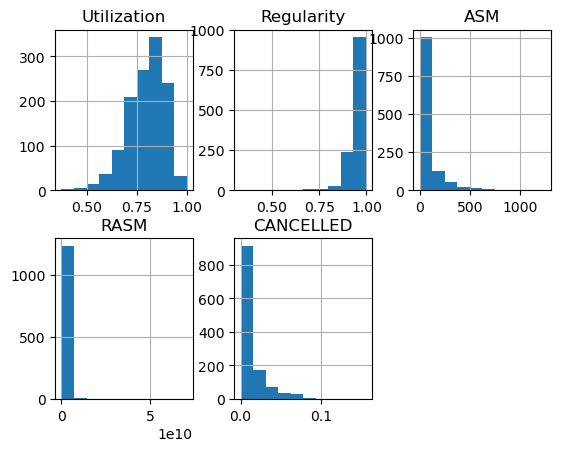

In [4]:
data[['Utilization', 'Regularity', 'ASM', 'RASM', 'CANCELLED']].hist(layout = (2,3));

In [5]:
# Create a graph
G = nx.from_pandas_edgelist(data, source = 'Origin_Airport_Code', target = 'Destination_Airport_Code', create_using = nx.DiGraph, edge_attr = ['Utilization', 'Regularity', 'CANCELLED', 'ASM', 'RASM'])
# Calculate degree centrality for each airport
degree_centrality = nx.degree_centrality(G)
# Calculate betweenness centrality for each airport
betweenness_centrality = nx.betweenness_centrality(G)

In [6]:
# Get the nodes and edges of the graph
nodes = [node for node in G.nodes()]
edges = [edge for edge in G.edges()]

## Create lables for outliers (hub points)

### Use degree centrality as the attribute

In [7]:
X = np.array(list(degree_centrality.values())).reshape(-1, 1)
lof_deg = LocalOutlierFactor(n_neighbors = 20).fit(X)
# Nodes with LOF greater than 1.5 are identified as outliers (i.e negative outlier factor < -1.5)
outliers_deg = [nodes[i] for i in np.where(lof_deg.negative_outlier_factor_ < lof_deg.offset_)[0]]
# Create labels (1: inliers, -1: outliers)
y_deg = np.array([-1 if i in outliers_deg else 1 for i in nodes])
print('--LOF with Degree Centrality--')
print('Outliers are {}'.format(outliers_deg))

--LOF with Degree Centrality--
Outliers are ['BWI', 'DAL', 'DEN', 'HOU', 'LAS', 'LAX', 'MDW', 'OAK', 'PHX', 'MCO', 'TPA', 'BNA', 'CMH', 'DCA', 'IND', 'MKE', 'MSY', 'SAN', 'SAT', 'STL', 'SJC', 'SMF']


### Use betweenness centrality as the attribute

In [8]:
X = np.array(list(betweenness_centrality.values())).reshape(-1, 1)
lof_betw = LocalOutlierFactor(n_neighbors = 20).fit(X)
# Nodes with LOF greater than 1.5 are identified as outliers (i.e negative outlier factor < -1.5)
outliers_betw = [nodes[i] for i in np.where(lof_betw.negative_outlier_factor_ < lof_betw.offset_)[0]]
# Create labels (1: inliers, -1: outliers)
y_betw = np.array([-1 if i in outliers_betw else 1 for i in nodes])
print('--LOF with Betweenness Centrality--')
print('Outliers are {}'.format(outliers_betw))

--LOF with Betweenness Centrality--
Outliers are ['ABQ', 'BWI', 'DAL', 'DEN', 'HOU', 'LAS', 'LAX', 'MDW', 'OAK', 'PHX', 'ALB', 'FLL', 'MCO', 'TPA', 'ATL', 'AUS', 'BNA', 'BOS', 'CLE', 'CMH', 'DCA', 'IND', 'LGA', 'MCI', 'MKE', 'MSP', 'MSY', 'PBI', 'PHL', 'PIT', 'RSW', 'SAN', 'SAT', 'STL', 'ELP', 'EWR', 'SFO', 'SJC', 'SMF', 'BDL', 'BHM', 'RDU', 'BOI', 'GEG', 'BUF', 'BUR', 'PDX', 'SLC', 'GRR', 'ISP', 'MEM', 'MHT', 'OKC', 'PVD', 'ROC', 'SDF', 'SJU', 'OMA', 'SEA', 'SNA', 'ONT', 'RNO', 'TUS', 'LGB']


### Compare the outliers identified with Degree Centrality and Betweenness Centrality

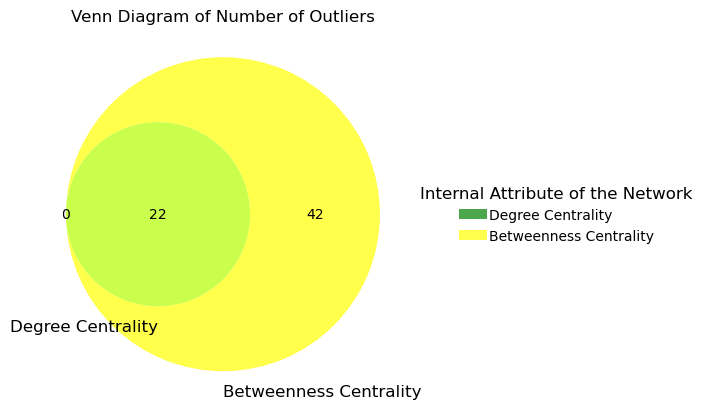

In [9]:
from matplotlib_venn import venn2

venn = venn2([set(outliers_deg), set(outliers_betw)], set_labels=('Degree Centrality', 'Betweenness Centrality'), set_colors=('green', 'yellow'), alpha = 0.7)
plt.legend(('Degree Centrality', 'Betweenness Centrality'), loc='center left', bbox_to_anchor=(1, 0.5), frameon = False, prop = {'size': 10}, markerscale = 1.5, title = 'Internal Attribute of the Network', title_fontsize = 12, handletextpad = 0.2)
plt.title('Venn Diagram of Number of Outliers')
plt.show()

#### All outliers recognized using degree centrality belong to those identified using betweenness centrality

In [10]:
# Find the common outliers
common_outliers = set(outliers_deg).intersection(outliers_betw)
# Find the unique outliers identified using betweenness centrality
unique_outliers_betw = [i for i in outliers_betw if i not in common_outliers]
print("Number of Common is: {}".format(len(outliers_deg)))
print("Number of Unique Outliers obtained using Betweenness Centrality is: {}".format(len(unique_outliers_betw)))

Number of Common is: 22
Number of Unique Outliers obtained using Betweenness Centrality is: 42


### Use LOF to identify anomaly edges based on Utilization, Regularity, CANCELLED, ASM, RASM metrics

In [11]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# Normalize the features so that they are on the same scale
X = data.loc[:, ['Utilization', 'Regularity', 'CANCELLED', 'ASM', 'RASM']]
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Compute the LOF scores based on the metrics
lof = LocalOutlierFactor(n_neighbors = 10)
lof_scores = lof.fit_predict(X)
outliers = [edges[i] for i in np.where(lof.negative_outlier_factor_ < lof.offset_)[0]]
outliers

[('BWI', 'SMF'),
 ('DEN', 'GRR'),
 ('DEN', 'MCO'),
 ('HOU', 'SNA'),
 ('LAS', 'MKE'),
 ('LAS', 'ONT'),
 ('LAX', 'BNA'),
 ('LAX', 'SFO'),
 ('MDW', 'BWI'),
 ('PHX', 'CMH'),
 ('PHX', 'DEN'),
 ('PHX', 'ELP'),
 ('FLL', 'IND'),
 ('MCO', 'ATL'),
 ('MCO', 'AUS'),
 ('MCO', 'PHL'),
 ('BNA', 'CLE'),
 ('DCA', 'STL'),
 ('DTW', 'STL'),
 ('PHL', 'HOU'),
 ('PHL', 'MCO'),
 ('RSW', 'BNA'),
 ('STL', 'RSW'),
 ('ELP', 'HOU'),
 ('HRL', 'AUS'),
 ('HRL', 'HOU'),
 ('SJC', 'HOU'),
 ('SJC', 'PHX'),
 ('BDL', 'TPA'),
 ('PDX', 'STL')]

## Fine-tuning p q in Node2Vec

In [ ]:
# Define the hyperparameters to search over
hyperparams = {
    'p': [0.1, 0.25, 0.5, 0.75, 0.9, 1],
    'q': [0.1, 0.25, 0.5, 0.75, 0.9, 1]
}
best_p_q = dict()

# Generate all possible combinations of hyperparameters
param_grid = ParameterGrid(hyperparams)
# Initialize the evaluation metric
best_f1_score = -1
# Iterate over each combination of hyperparameters
for params in param_grid:
    if params['p'] >= params['q']:
        continue
    print(params)
    # Initialize a Node2Vec object with the weighted graph and the weight keys
    node2vec = Node2Vec(G, dimensions = 32, walk_length = 30, num_walks = 100,  p = params['p'], q = params['q'], weight_key = ('Utilization', 'Regularity', 'CANCELLED', 'ASM', 'RASM'))
    # Train the node2vec model
    model = node2vec.fit(window = 10, min_count = 1)
    # Get the node embeddings
    embeddings = np.zeros((G.number_of_nodes(), model.vector_size))
    for i, node in enumerate(G.nodes()):
        embeddings[i] = model.wv[node]
    # Apply LOF to predict outlies based on the embeddings
        lof_n2v = LocalOutlierFactor(n_neighbors = 20).fit(embeddings)
        outliers_n2v = [nodes[i] for i in np.where(lof_n2v.negative_outlier_factor_ < lof_n2v.offset_)[0]]
        y_pred_lof = np.array([-1 if i in outliers_n2v else 1 for i in nodes])
        f1 = f1_score(y_deg, y_pred_lof)
        if f1 >= best_f1_score:
            best_f1_score = f1
            best_p_q['p'], best_p_q['q']  = params['p'], params['q']
            node_embeddings = embeddings

{'p': 0.1, 'q': 0.25}


Computing transition probabilities:   0%|          | 0/85 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 100/100 [00:01<00:00, 87.36it/s]


{'p': 0.1, 'q': 0.5}


Computing transition probabilities:   0%|          | 0/85 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 100/100 [00:01<00:00, 86.07it/s]


{'p': 0.1, 'q': 0.75}


Computing transition probabilities:   0%|          | 0/85 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 100/100 [00:01<00:00, 84.72it/s]


{'p': 0.1, 'q': 0.9}


Computing transition probabilities:   0%|          | 0/85 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 100/100 [00:01<00:00, 84.57it/s]


{'p': 0.1, 'q': 1}


Computing transition probabilities:   0%|          | 0/85 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 100/100 [00:01<00:00, 86.65it/s]


{'p': 0.25, 'q': 0.5}


Computing transition probabilities:   0%|          | 0/85 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 100/100 [00:01<00:00, 88.05it/s]


{'p': 0.25, 'q': 0.75}


Computing transition probabilities:   0%|          | 0/85 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 100/100 [00:01<00:00, 82.69it/s]


{'p': 0.25, 'q': 0.9}


Computing transition probabilities:   0%|          | 0/85 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 100/100 [00:01<00:00, 78.10it/s]


{'p': 0.25, 'q': 1}


Computing transition probabilities:   0%|          | 0/85 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 100/100 [00:01<00:00, 85.51it/s]


{'p': 0.5, 'q': 0.75}


Computing transition probabilities:   0%|          | 0/85 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 100/100 [00:01<00:00, 85.38it/s]


{'p': 0.5, 'q': 0.9}


Computing transition probabilities:   0%|          | 0/85 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 100/100 [00:01<00:00, 84.59it/s]


{'p': 0.5, 'q': 1}


Computing transition probabilities:   0%|          | 0/85 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 100/100 [00:01<00:00, 82.32it/s]


In [ ]:
best_p_q

In [ ]:
best_f1_score

## IsolationRandomForest

In [ ]:
# create an IsolationForest object
isolation_forest = IsolationForest(n_estimators = 100, contamination = 0.15, random_state = 42)

# fit the IsolationForest model to the embeddings
isolation_forest.fit(node_embeddings)
# get the average anomaly
outlier_scores_isof = isolation_forest.decision_function(node_embeddings)

plt.figure(figsize=(8, 6))
plt.hist(outlier_scores_isof, bins = 50)
plt.xlabel("outlier score")
plt.ylabel("Frequency")
plt.title("Isolation Random Forest");

In [ ]:
# Identify the anomaly nodes based on positiveness of the scores (inliers: positive score; outliers: negative score)
outliers_isof = [nodes[i] for i in np.where(outlier_scores_isof < 0)[0]]
print("Anomaly nodes:", outliers_isof)

### One class SVM 
Since we don't have the labels for the airport such that we can assume all nodes belongs to only one class. OC-SVM uses the origin as the other class

In [ ]:
# Train the One-Class SVM
svm = svm.OneClassSVM(nu = 0.5, kernel = "rbf", gamma = 0.1)
svm.fit(node_embeddings)

# Predict the anomaly scores for all embeddings
outlier_scores_svm = svm.decision_function(node_embeddings)

In [ ]:
plt.hist(outlier_scores_svm, bins = 50)
plt.xlabel("outlier score")
plt.ylabel("Frequency")
plt.title("One Class SVM");

In [ ]:
# Identify nodes as anomalies if its anomaly scoce is below zero
outliers_svm = [nodes[i] for i in np.where(outlier_scores_svm < 0)[0]]
print("Anomaly nodes:", outliers_svm)

In [ ]:
potential_outliers = set(outliers_isof).intersection(outliers_svm)
potential_outliers

### Two-sample t-test with unequal variances for removing potential hub points identified using graph anomaly detection

In [ ]:
from scipy import stats
def ttest_removing_potential_hubs(data, metric, node):
    t_stat, p_val = stats.ttest_ind(data[data['citypair'].str.contains(node)][metric], data[~data['citypair'].str.contains(node)][metric], equal_var = False)
    return p_val

In [ ]:
uncertain_nodes = [node for node in potential_outliers if len(data[data['citypair'].str.contains(node)]) <= 2]
new_candidates = [node for node in potential_outliers if node not in uncertain_nodes]
metrics = ['CANCELLED', 'Utilization', 'Regularity', 'ASM', 'RASM']
res = {}
for node in new_candidates:
    for metric in metrics:
        p_val = ttest_removing_potential_hubs(data, metric, node)
        if p_val > 0.05:
            if node not in res:
                res[node] = [(metric, p_val)]
            else:
                res[node].append((metric, p_val))

In [ ]:
res

In [ ]:
for node in uncertain_nodes:
    display(data[data['citypair'].str.contains(node)])